In [1]:
import gc
gc.collect()

19

In [834]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics.cluster import silhouette_score
from matplotlib import font_manager, rc

plt.rc('font', family='AppleGothic') # 한글출력
plt.rcParams['axes.unicode_minus'] = False # 축 -표시

font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

In [857]:
train = pd.read_csv('./train_pre2.csv')
test = pd.read_csv('./test_pre2.csv')
valid = pd.read_csv('./valid_pre2.csv')

In [859]:
# 결측 채우기 위해 모두 병합
all_df = pd.concat([train,valid,test],axis=0)
train.shape,all_df.shape

C:\Users\samsung\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


((59199, 191), (69054, 191))

In [838]:
# 적대검증 순위 1군집 컬럼들
adv_col = ['ahsm_dstnc', 'hm_cnt', 'bldng_ar_prc', 'no_tbc_zn_dstnc', 'cctv_dstnc', 
 'sft_emrgnc_bll_dstnc', 'tbc_rtl_str_dstnc', 'fr_sttn_dstnc', 
 'fr_wthr_fclt_dstnc', 'ttl_ar', 'bldng_ar', 'lnd_ar', 
 'bldng_cnt_in_50m', 'bldng_cnt', 'ttl_grnd_flr']
# 
input_var = list(set(train.columns) - set(['id','dt_of_fr','fr_yn']))
target = ['fr_yn']

cate_col = []
for col in train[input_var].columns:
    if (train[col].dtype == 'object'):
        cate_col.append(col)
cate_col = cate_col + ['wnd_drctn']
cate_col.remove('dt_of_athrztn')

ValueError: list.remove(x): x not in list

In [839]:
train.loc[train[col].isin(list(set(train[col].unique()) - set(valid[col].unique())))].shape[0]

34601

In [36]:
# 범주형 변수별, train에만 있는 값들과 해당되는 건물id 개수
for col in cate_col:
    #print(train.loc[train[col].isin(list(set(train[col].unique()) - set(valid[col].unique())))].shape[0])
    print(col,':',train.loc[train[col].isin(list(set(train[col].unique()) - set(valid[col].unique())))].shape[0],' : ',set(train[col].unique()) - set(valid[col].unique()) )

jmk : 69  :  {'양'}
blk_dngrs_thng_mnfctr_yn : 1  :  {'Y'}
trgt_crtr : 33  :  {'연면적 15,000 이상', '콘테이너하우스', '펜션7실이하', '기타(가설건축물분류)', '임시사무실,창고,숙소', '11층이상', '공동주택(주택법시행령제63조제1항각호1에해당)', '주거용비닐하우스', '기타', '견본주택(모델하우스)'}
bldng_archtctr : 14  :  {'프리케스트콘크리트구조'}
rgnl_ar_nm2 : 81  :  {'근린상업지역', '보전녹지지역', '자연환경보전지역'}
bldng_us_clssfctn : 0  :  set()
mlt_us_yn : 0  :  set()
bldng_us : 63  :  {'교육연구및복지시설', '장례식장', '수련시설', '발전시설', '공공용시설', '판매및영업시설', '시장', '파출소', '운수시설'}
us_yn : 0  :  set()
rgnl_ar_nm : 1650  :  {'보전녹지지역', '자연환경보전지역', '유통상업지역', '용도미지정', '관리지역', '제1종전용주거지역'}
lnd_us_sttn_nm : 41  :  {'유원지', '콘도미니엄', '여객자동차터미널', '발전소', '스키장', '목장용지', '특수기타'}
fr_fghtng_fclt_spcl_css_5_yn : 0  :  set()
cltrl_hrtg_yn : 1  :  {'Y'}
fr_fghtng_fclt_spcl_css_6_yn : 0  :  set()
dngrs_thng_yn : 0  :  set()
slf_fr_brgd_yn : 0  :  set()
rd_sd_nm : 0  :  set()
wnd_drctn : 226  :  {nan, 2.0, 36.0, 11.0, 23.0, 29.0}


- ex) rgnl_ar_nm의 경우, train에만 있는 범주는 {'보전녹지지역', '자연환경보전지역', '유통상업지역', '용도미지정', '관리지역', '제1종전용주거지역'}이고 이 범주에 해당하는 id는 1650개이다.

## 범주형 변수들 중에 겹치지 않는 값을 통합하는 과정
## (+ 결측치 채우는 과정)

### (참고자료) 김해도시관리계획(재정비 및 관리지역 세분) 결정(변경) 고시 2008

1. jmk : '양'은 양어장이고 test에는 없지만 김해에는 있으므로 추가

2. trgt_crtr : 


3. bldng_archtctr : 

    '프리케스트콘크리트구조':

    건축구조물의 주요 Member인 기둥, 보, 슬라브 등의 부재를 안정적인 환경의 PC전용 공장에서 전용 몰드(형틀)에 철근 배근후 콘크리트를 타설하여 제품을 생산하는 방식

-> 철근 콘크리트 구조로 변경

Text(0.5, 1.0, '철근콘크리트구조')

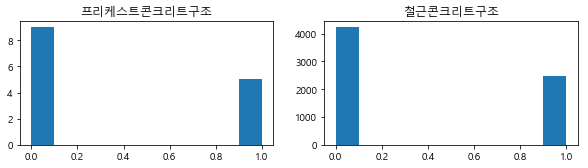

In [26]:
plt.figure(figsize=(10,5))
ax1 = plt.subplot(2,2,1)
ax2 = plt.subplot(2,2,2)

ax1.hist(train[train['bldng_archtctr']=='프리케스트콘크리트구조']['fr_yn'])
ax2.hist(train[train['bldng_archtctr']=='철근콘크리트구조']['fr_yn'])
ax1.set_title('프리케스트콘크리트구조')
ax2.set_title('철근콘크리트구조')


In [860]:
train['bldng_archtctr'] = np.where(train['bldng_archtctr']=='프리케스트콘크리트구조', 
                                   '철근콘크리트구조',train['bldng_archtctr'])
valid['bldng_archtctr'] = np.where(valid['bldng_archtctr']=='프리케스트콘크리트구조', 
                                   '철근콘크리트구조',valid['bldng_archtctr'])
test['bldng_archtctr'] = np.where(test['bldng_archtctr']=='프리케스트콘크리트구조', 
                                   '철근콘크리트구조',test['bldng_archtctr'])

4. rgnl_ar_nm2 : {'근린상업지역', '보전녹지지역', '자연환경보전지역'}

-> 자연녹지지역은 개발 가능성이 있는 곳

-> {'자연환경보전지역'} = 보전관리지역

-> 보전녹지지역,근린상업지역은 김해시에 있으므로 그대로 

In [861]:
train['rgnl_ar_nm2'] = np.where(train['rgnl_ar_nm2']=='자연환경보전지역', 
                                   '보전관리지역',train['rgnl_ar_nm2'])
valid['rgnl_ar_nm2'] = np.where(valid['rgnl_ar_nm2']=='자연환경보전지역', 
                                   '보전관리지역',valid['rgnl_ar_nm2'])
test['rgnl_ar_nm2'] = np.where(test['rgnl_ar_nm2']=='자연환경보전지역', 
                                   '보전관리지역',test['rgnl_ar_nm2'])

5. rgnl_ar_nm  {'보전녹지지역', '자연환경보전지역', '유통상업지역', '용도미지정', '관리지역', '제1종전용주거지역'}

-> {자연환경보전지역} = 보전관리지역

-> {제1종전용주거지역}은 가장 유사한 {제1종일반주거지역}으로 변경

In [862]:
# 제1종전용주거지역은 가장 유사한 제1종일반주거지역으로 변경
train['rgnl_ar_nm'] = np.where(train['rgnl_ar_nm']=='제1종전용주거지역', 
                                   '제1종일반주거지역',train['rgnl_ar_nm'])
valid['rgnl_ar_nm'] = np.where(valid['rgnl_ar_nm']=='제1종전용주거지역', 
                                   '제1종일반주거지역',valid['rgnl_ar_nm'])
test['rgnl_ar_nm'] = np.where(test['rgnl_ar_nm']=='제1종전용주거지역', 
                                   '제1종일반주거지역',test['rgnl_ar_nm'])

### 6. bldng_us {'교육연구및복지시설', '장례식장', '수련시설', '발전시설', '공공용시설', '판매및영업시설', '시장', '파출소', '운수시설'}

In [692]:
valid['bldng_us'].unique()

array(['단독주택', nan, '공장', '제1종근린생활시설', '제2종근린생활시설', '위험물저장및처리시설',
       '교육연구시설', '동.식물 관련시설', '공동주택', '창고시설', '의료시설', '종교시설', '숙박시설',
       '방송통신시설', '묘지관련시설', '분뇨.쓰레기처리시설', '위락시설', '노유자시설', '업무시설', '판매시설',
       '관광휴게시설', '근린생활시설', '자동차관련시설', '운동시설', '문화및집회시설', '교정및군사시설'],
      dtype=object)

In [863]:
# 결측 채우기
def fill_blgng_us(train, valid, test, all_df):
    bld_us_df = all_df.groupby(['lnd_us_sttn_nm','jmk','rgnl_ar_nm','bldng_us']).count()[['dt_of_fr']]\
     / all_df[all_df['bldng_us'].isna()==False].groupby(['lnd_us_sttn_nm','jmk','rgnl_ar_nm']).count()[['dt_of_fr']]
    bld_us_df_85 = bld_us_df[bld_us_df['dt_of_fr']>=0.9].reset_index()

    all_df['bldng_us2'] = all_df['bldng_us']
    for i in range(bld_us_df_85.shape[0]):
        all_df['bldng_us2'] = np.where((all_df['lnd_us_sttn_nm']==bld_us_df_85['lnd_us_sttn_nm'].iloc[i]) 
                 &(all_df['jmk']==bld_us_df_85['jmk'].iloc[i]) &(all_df['rgnl_ar_nm']==bld_us_df_85['rgnl_ar_nm'].iloc[i])
                                      & (all_df['bldng_us'].isna()), bld_us_df_85['bldng_us'].iloc[i], all_df['bldng_us2'])
    train = pd.merge(train, all_df[['id','bldng_us2']], on='id',how='left')
    train['bldng_us'] = train['bldng_us2']
    train = train.drop('bldng_us2', axis=1)
    
    valid = pd.merge(valid, all_df[['id','bldng_us2']], on='id',how='left')
    valid['bldng_us'] = valid['bldng_us2']
    valid = valid.drop('bldng_us2', axis=1)
    test = pd.merge(test, all_df[['id','bldng_us2']], on='id',how='left')
    test['bldng_us'] = test['bldng_us2']
    test = test.drop('bldng_us2', axis=1)
    
    del bld_us_df
    del bld_us_df_85
    del all_df['bldng_us2']
    return train, valid, test

In [864]:
train,valid,test = fill_blgng_us(train, valid, test, all_df)

### 7. bldng_us_clssfctn

#### 공동주택이고 아파트일떄 주거용인지 상업용인지 구분하는 모델 생성

In [789]:
from tqdm import tqdm_notebook
from sklearn.preprocessing import LabelEncoder

train2 = pd.read_csv('./train_pre2.csv')
test2 = pd.read_csv('./test_pre2.csv')
valid2 = pd.read_csv('./valid_pre2.csv')

apart_or_not = pd.concat([train2, valid2, test2], axis=0)
apart_or_not= all_df[(all_df['bldng_us']=='공동주택') & (all_df['lnd_us_sttn_nm']=='아파트')]

input_var2 = list(set(apart_or_not.columns) - set(['id','dt_of_fr','bldng_us_clssfctn']))

cate_col2 = []
for col in train2[input_var2].columns:
    if (train2[col].dtype == 'object'):
        cate_col2.append(col)

cate_col2 = cate_col2 + ['month','hour','weekday','wnd_drctn']
cate_col2 = list(set(cate_col2) & set(apart_or_not.columns))
#cate_col2.remove('bldng_us_clssfctn')

for col in tqdm_notebook(apart_or_not.columns): 
    if col in cate_col2:
        le = LabelEncoder()
        le.fit(list(apart_or_not[col].astype(str).values))
        apart_or_not[col] = le.transform(list(apart_or_not[col].astype(str).values))

C:\Users\samsung\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


C:\Users\samsung\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [787]:
apart_or_not = pd.get_dummies(apart_or_not, columns=cate_col2)
apart_or_not = apart_or_not.fillna(-99)

input_var2 = list(set(apart_or_not.columns) - set(['id','dt_of_fr','bldng_us_clssfctn']))
target = ['bldng_us_clssfctn']

In [778]:
apart_or_not = pd.get_dummies(apart_or_not, columns=cate_col2)
apart_or_not = apart_or_not.fillna(-99)

input_var2 = list(set(apart_or_not.columns) - set(['id','dt_of_fr','bldng_us_clssfctn']))
target = ['bldng_us_clssfctn']

X_testt = apart_or_not[apart_or_not['bldng_us_clssfctn']==-99]
apart_or_not = apart_or_not[(apart_or_not['bldng_us_clssfctn']!=-99) & (apart_or_not['bldng_us_clssfctn']!='기타')]
apart_or_not['bldng_us_clssfctn'] = np.where(apart_or_not['bldng_us_clssfctn']=='주거용', 1,0)

X = apart_or_not[input_var2]
y = apart_or_not[target]

C:\Users\samsung\Anaconda3\lib\site-packages\ipykernel_launcher.py:85: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\samsung\Anaconda3\lib\site-packages\ipykernel_launcher.py:85: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\samsung\Anaconda3\lib\site-packages\ipykernel_launcher.py:85: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\samsung\Anaconda3\lib\site-packages\ipykernel_launcher.py:85: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\samsung\Anaconda3\lib\site-packages\ipykernel_launcher.py:85: DataConversionWarning: A 

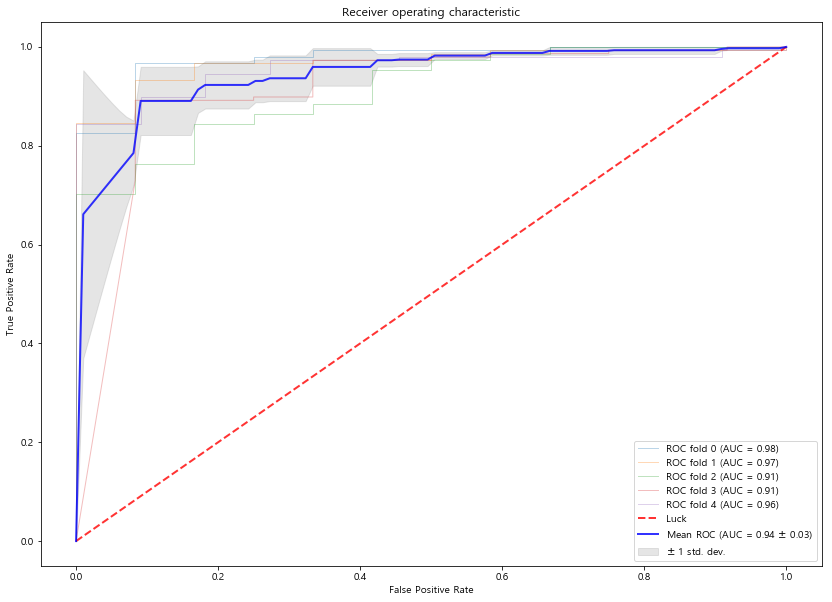

,AUC Train,AUC Test
0,0.993685,0.975951
1,0.996986,0.967562
2,0.994484,0.914414
3,0.993624,0.911036
4,0.996598,0.957002


In [779]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
# https://www.kaggle.com/ynouri/random-forest-k-fold-cross-validation
def plot_roc_curve(fprs, tprs):
    """Plot the Receiver Operating Characteristic from a list
    of true positive rates and false positive rates."""
    
    # Initialize useful lists + the plot axes.
    tprs_interp = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    f, ax = plt.subplots(figsize=(14,10))
    
    # Plot ROC for each K-Fold + compute AUC scores.
    for i, (fpr, tpr) in enumerate(zip(fprs, tprs)):
        tprs_interp.append(np.interp(mean_fpr, fpr, tpr))
        tprs_interp[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        ax.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        
    # Plot the luck line.
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)
    
    # Plot the mean ROC.
    mean_tpr = np.mean(tprs_interp, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)
    
    # Plot the standard deviation around the mean ROC.
    std_tpr = np.std(tprs_interp, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')
    
    # Fine tune and show the plot.
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic')
    ax.legend(loc="lower right")
    plt.show()
    return (f, ax)

def compute_roc_auc(index):
    y_predict = clf.predict_proba(X.iloc[index])[:,1]
    fpr, tpr, thresholds = roc_curve(y.iloc[index], y_predict)
    auc_score = auc(fpr, tpr)
    return fpr, tpr, auc_score

# 학습
clf = RandomForestClassifier(
    n_estimators=50,
    criterion='gini',
    max_depth=5,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features='auto',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    min_impurity_split=None,
    bootstrap=True,
    oob_score=False,
    n_jobs=-1,
    random_state=0,
    verbose=0,
    warm_start=False,
    class_weight='balanced'
)

cv = StratifiedKFold(n_splits=5, shuffle=False)
results = pd.DataFrame(columns=['training_score', 'test_score'])
fprs, tprs, scores = [], [], []
    
for (trainn, test), i in zip(cv.split(X, y), range(5)):
    clf.fit(X.iloc[trainn], y.iloc[trainn])
    _, _, auc_score_train = compute_roc_auc(trainn)
    fpr, tpr, auc_score = compute_roc_auc(test)
    scores.append((auc_score_train, auc_score))
    fprs.append(fpr)
    tprs.append(tpr)

plot_roc_curve(fprs, tprs);
pd.DataFrame(scores, columns=['AUC Train', 'AUC Test'])

In [780]:
X_testt['bldng_us_clssfctn2'] = clf.predict(X_testt[input_var2])
amart_pred =X_testt[['id','bldng_us_clssfctn2']]
amart_pred['bldng_us_clssfctn2'] = np.where(amart_pred['bldng_us_clssfctn2']==1, '주거용','상업용')

C:\Users\samsung\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [783]:
amart_pred

,id,bldng_us_clssfctn2
24603,108022,주거용
34703,115455,주거용
44651,79678,주거용
3251,103906,주거용
4026,118060,주거용
5396,79730,주거용
2520,102847,주거용


In [781]:
train = pd.merge(train, amart_pred, on='id', how='left')
train['bldng_us_clssfctn'] = np.where(train['bldng_us_clssfctn'].isna(), train['bldng_us_clssfctn2'],train['bldng_us_clssfctn'])
train = train.drop('bldng_us_clssfctn2', axis=1)

valid = pd.merge(valid, amart_pred, on='id', how='left')
valid['bldng_us_clssfctn'] = np.where(valid['bldng_us_clssfctn'].isna(), valid['bldng_us_clssfctn2'],valid['bldng_us_clssfctn'])
valid = train.drop('bldng_us_clssfctn2', axis=1)

test = pd.merge(test, amart_pred, on='id', how='left')
test['bldng_us_clssfctn'] = np.where(test['bldng_us_clssfctn'].isna(), test['bldng_us_clssfctn2'],test['bldng_us_clssfctn'])
test = test.drop('bldng_us_clssfctn2', axis=1)

KeyError: "['bldng_us_clssfctn2'] not found in axis"

#### 나머지 결측 처리

In [865]:
# 위락시설은 상업용
train['bldng_us_clssfctn'] = np.where((train['bldng_us']=='위락시설') & (train['bldng_us_clssfctn'].isna()),
                                     '상업용', train['bldng_us_clssfctn'])
# 교정및군사시설은 공공용
train['bldng_us_clssfctn'] = np.where((train['bldng_us']=='교정및군사시설') & (train['bldng_us_clssfctn'].isna()),
                                     '공공용', train['bldng_us_clssfctn'])
# 교정및군사시설은 공공용
train['bldng_us_clssfctn'] = np.where((train['bldng_us']=='방송통신시설') & (train['bldng_us_clssfctn'].isna()),
                                     '상업용', train['bldng_us_clssfctn'])
# 창고시설은 공공용
train['bldng_us_clssfctn'] = np.where((train['bldng_us']=='창고시설') & (train['bldng_us_clssfctn'].isna()),
                                     '기타', train['bldng_us_clssfctn'])
# 운동시설은 문교사회용
train['bldng_us_clssfctn'] = np.where((train['bldng_us']=='운동시설') & (train['bldng_us_clssfctn'].isna()),
                                     '문교사회용', train['bldng_us_clssfctn'])
# 종교시설은 문교사회용
train['bldng_us_clssfctn'] = np.where((train['bldng_us']=='종교시설') & (train['bldng_us_clssfctn'].isna()),
                                     '문교사회용', train['bldng_us_clssfctn'])
# 교육연구시설은 문교사회용
train['bldng_us_clssfctn'] = np.where((train['bldng_us']=='교육연구시설') & (train['bldng_us_clssfctn'].isna()),
                                     '문교사회용', train['bldng_us_clssfctn'])
# 노유자시설은 문교사회용
train['bldng_us_clssfctn'] = np.where((train['bldng_us']=='노유자시설') & (train['bldng_us_clssfctn'].isna()),
                                     '문교사회용', train['bldng_us_clssfctn'])
# 숙박시설은 문교사회용
train['bldng_us_clssfctn'] = np.where((train['bldng_us']=='숙박시설') & (train['bldng_us_clssfctn'].isna()),
                                     '상업용', train['bldng_us_clssfctn'])


In [866]:
# 결측 채우기
def fill_bldng_us_clssfctn(train, valid, test, all_df):
    bld_us_df = all_df.groupby(['bldng_us','jmk','lnd_us_sttn_nm','bldng_us_clssfctn']).count()[['dt_of_fr']]\
    / all_df[all_df['bldng_us_clssfctn'].isna()==False].groupby(['bldng_us','jmk','lnd_us_sttn_nm']).count()[['dt_of_fr']]
    bld_us_df_85 = bld_us_df[bld_us_df['dt_of_fr']>=0.9].reset_index()

    all_df['bldng_us_clssfctn2'] = all_df['bldng_us_clssfctn']
    for i in range(bld_us_df_85.shape[0]):
        all_df['bldng_us_clssfctn2'] = np.where((all_df['lnd_us_sttn_nm']==bld_us_df_85['lnd_us_sttn_nm'].iloc[i]) 
                 &(all_df['jmk']==bld_us_df_85['jmk'].iloc[i])
                 & (all_df['bldng_us_clssfctn'].isna()), bld_us_df_85['bldng_us_clssfctn'].iloc[i], all_df['bldng_us_clssfctn2'])
    train = pd.merge(train, all_df[['id','bldng_us_clssfctn2']], on='id',how='left')
    train['bldng_us_clssfctn'] = train['bldng_us_clssfctn2']
    train = train.drop('bldng_us_clssfctn2', axis=1)
    
    valid = pd.merge(valid, all_df[['id','bldng_us_clssfctn2']], on='id',how='left')
    valid['bldng_us_clssfctn'] = valid['bldng_us_clssfctn2']
    valid = valid.drop('bldng_us_clssfctn2', axis=1)
    test = pd.merge(test, all_df[['id','bldng_us_clssfctn2']], on='id',how='left')
    test['bldng_us_clssfctn'] = test['bldng_us_clssfctn2']
    test = test.drop('bldng_us_clssfctn2', axis=1)
    
    del bld_us_df
    del bld_us_df_85
    del all_df['bldng_us_clssfctn2']
    return train, valid, test

In [867]:
train,valid,test = fill_bldng_us_clssfctn(train, valid, test, all_df)

### 8. trgt_crtr(소방점검대상물기준)

In [806]:
all_df['trgt_crtr'].isna().sum()

60140

In [807]:
valid['trgt_crtr'].unique()

array([nan, '일반대상물', '스프링클러,물분무등설치대상', '자동화재탐지설치대상', '펜션7실이상', '민박7실이하',
       '옥내소화전설치대상', '민박7실이상'], dtype=object)

In [868]:
# 헤딩 조건에서 일반건축물인 경우는 83, 2건 뿐
train['trgt_crtr'] = np.where((train['lnd_us_sttn_nm']=='단독') & (train['bldng_us']=='단독주택') 
      & (train['bldng_us_clssfctn']=='주거용') & (train['rgnl_ar_nm']=='제2종일반주거지역'), '단독',train['trgt_crtr'])
valid['trgt_crtr'] = np.where((valid['lnd_us_sttn_nm']=='단독') & (valid['bldng_us']=='단독주택') 
      & (valid['bldng_us_clssfctn']=='주거용') & (valid['rgnl_ar_nm']=='제2종일반주거지역'), '단독',valid['trgt_crtr'])
test['trgt_crtr'] = np.where((test['lnd_us_sttn_nm']=='단독') & (test['bldng_us']=='단독주택') 
      & (test['bldng_us_clssfctn']=='주거용') & (test['rgnl_ar_nm']=='제2종일반주거지역'), '단독',test['trgt_crtr'])

### 9. lnd_us_sttn_nm

In [809]:
all_df['lnd_us_sttn_nm'].isna().sum()

2012

In [869]:
# 결측 채우기
def fill_lnd_us_sttn_nm(train, valid, test, all_df):
    bld_us_df = all_df.groupby(['bldng_us','jmk','rgnl_ar_nm','lnd_us_sttn_nm']).count()[['dt_of_fr']]\
    / all_df[all_df['lnd_us_sttn_nm'].isna()==False].groupby(['bldng_us','jmk','rgnl_ar_nm']).count()[['dt_of_fr']]
    bld_us_df_85 = bld_us_df[bld_us_df['dt_of_fr']>=0.9].reset_index()

    all_df['lnd_us_sttn_nm2'] = all_df['lnd_us_sttn_nm']
    for i in range(bld_us_df_85.shape[0]):
        all_df['lnd_us_sttn_nm2'] = np.where((all_df['bldng_us']==bld_us_df_85['bldng_us'].iloc[i]) 
                 &(all_df['jmk']==bld_us_df_85['jmk'].iloc[i]) &(all_df['rgnl_ar_nm']==bld_us_df_85['rgnl_ar_nm'].iloc[i])
                 & (all_df['lnd_us_sttn_nm'].isna()), bld_us_df_85['lnd_us_sttn_nm'].iloc[i], all_df['lnd_us_sttn_nm2'])
    
    train = pd.merge(train, all_df[['id','lnd_us_sttn_nm2']], on='id',how='left')
    train['lnd_us_sttn_nm'] = train['lnd_us_sttn_nm2']
    train = train.drop('lnd_us_sttn_nm2', axis=1)
    
    valid = pd.merge(valid, all_df[['id','lnd_us_sttn_nm2']], on='id',how='left')
    valid['lnd_us_sttn_nm'] = valid['lnd_us_sttn_nm2']
    valid = valid.drop('lnd_us_sttn_nm2', axis=1)
    test = pd.merge(test, all_df[['id','lnd_us_sttn_nm2']], on='id',how='left')
    test['lnd_us_sttn_nm'] = test['lnd_us_sttn_nm2']
    test = test.drop('lnd_us_sttn_nm2', axis=1)
    
    del bld_us_df
    del bld_us_df_85
    del all_df['lnd_us_sttn_nm2']
    return train, valid, test

In [870]:
train,valid,test = fill_lnd_us_sttn_nm(train, valid, test, all_df)

In [871]:
train.to_csv('train_pre3.csv', index=False)
valid.to_csv('valid_pre3.csv', index=False)
test.to_csv('test_pre3.csv', index=False)

### 10. bldng_us_clssfctn

In [175]:
train['bldng_us_clssfctn'].unique()

array(['주거용', nan, '상업용', '문교사회용', '공업용', '농수산용', '기타', '공공용'],
      dtype=object)

In [ ]:
# (train['lnd_us_sttn_nm']=='공업용') & (train['bldng_us']=='공장' 이면 공업용 97.7%
train['bldng_us_clssfctn'] = np.where((train['lnd_us_sttn_nm']=='공업용') & (train['bldng_us']=='공장')
                                      & (train['bldng_us_clssfctn'].isna()),
                                     '공업용', train['bldng_us_clssfctn'])
# (train['rgnl_ar_nm']=='생산관리지역')& (train['bldng_us']=='창고시설')이면 기타 96.5%
train['bldng_us_clssfctn'] = np.where((train['rgnl_ar_nm']=='생산관리지역')& (train['bldng_us']=='창고시설')
                                       & (train['bldng_us_clssfctn'].isna()),
                                     '기타', train['bldng_us_clssfctn'])
# 제1,2종근린생활시설은 상업용이 90% 이상
train['bldng_us_clssfctn'] = np.where(((train['bldng_us']=='제1종근린생활시설') | (train['bldng_us']=='제2종근린생활시설'))
                                      & (train['bldng_us_clssfctn'].isna()),
                                     '상업용', train['bldng_us_clssfctn'])
# 분뇨.쓰레기 시설은 100% 기타
train['bldng_us_clssfctn'] = np.where((train['bldng_us']=='분뇨.쓰레기처리시설') & (train['bldng_us_clssfctn'].isna()),
                                     '기타', train['bldng_us_clssfctn'])
# 자동차관련시설은 99% 상업용
train['bldng_us_clssfctn'] = np.where((train['bldng_us']=='자동차관련시설') & (train['bldng_us_clssfctn'].isna()),
                                     '상업용', train['bldng_us_clssfctn'])
# 동식물 시설은 jmk=대 제외하면 90% 이상 농수산용
train['bldng_us_clssfctn'] = np.where((train['jmk']!='대')& (train['bldng_us']=='동.식물 관련시설')
                                       & (train['bldng_us_clssfctn'].isna()),
                                     '농수산용', train['bldng_us_clssfctn'])
# 업무 시설은 94% 상업용 
train['bldng_us_clssfctn'] = np.where((train['bldng_us']=='업무시설')& (train['lnd_us_sttn_nm']!='주거기타')
                                       & (train['bldng_us_clssfctn'].isna()),
                                     '상업용', train['bldng_us_clssfctn'])
train['bldng_us_clssfctn'] = np.where((train['bldng_us']=='업무시설')& (train['lnd_us_sttn_nm']=='주거기타')
                                       & (train['bldng_us_clssfctn'].isna()),
                                     '공공용', train['bldng_us_clssfctn'])